In this model we will use a latent factors model, a popular approach to [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering#:~:text=In%20the%20newer%2C%20narrower%20sense,from%20many%20users%20(collaborating).

We will be using a truncated [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition), because unlike a standard SVD, a truncated SVD produces a factorization where the number of columns can be specifies for a number of truncation, saving memory and processing power.

The sk-learn package has a module to build a truncated SVD. 

In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [10]:
#Read in data from a pickle file
df = pd.read_pickle("beer_data.pickle")

#Shorten the dataset for testing purposes
df = df.head(5000)

We create a sparse pivot table which groups together the data in a meaningful way so we can train it later.
In this case, we want out pivot table to contain the users, the item they rated, and the rating value. The rest of the values will be filled with 0s.

In [11]:
# create a sparse pivot table
df_pivot = df.pivot_table(index='review_profilename', columns='beer_name', values='review_overall').fillna(0)

Next we need to determine the number of components we want to use for our truncated SVD.

We decide this value by using Catell's [scree test](https://en.wikipedia.org/wiki/Scree_plot). We'll plot the eigenvalues of different component values, and determine the number of components that would best suit our TSVD.

In [12]:
T = df_pivot.values.T
T.shape

(475, 2137)

In [13]:
def explained_variance(list_n_components):
    
    out = []
    
    for num in list_n_components:
        SVD = TruncatedSVD(n_components=num,random_state=num)
        SVD.fit_transform(T)
        evar = np.sum(SVD.explained_variance_ratio_)
        t = (num,evar)
        out.append(t)
    
    return out

In [14]:
n = [50,100,150,200,250,300,400,600,700,1000,1200,1400,1500]
exp_var = explained_variance(n)

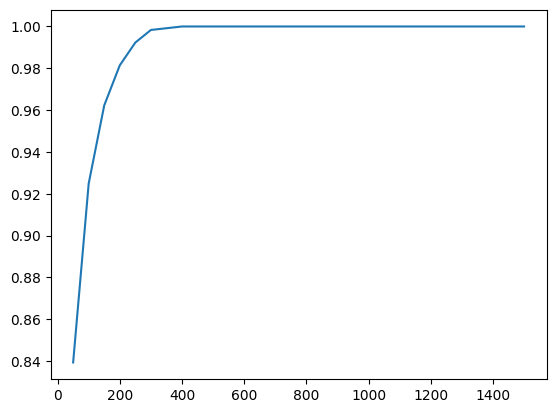

In [15]:
x,y = zip(*exp_var)
plt.plot(x, y)

Looking at the plot, we see that the number of components starts to level off at around 600 components.

So, we will create a TSVD with 600 components.

In [16]:
SVD = TruncatedSVD(n_components=600,random_state=600)
matrix = SVD.fit_transform(T)

In [17]:
#Create the correlation matrix
corr = np.corrcoef(matrix)

In [21]:
#Put all the beer names in a list
beer_names = df_pivot.columns
beer_names_list = list(beer_names)

print(beer_names_list)

["'Pooya Porter", '10 Blocks South', '15th Anniversary', '2001 - A Stout Odyssey', "Ackerman's Imperial Double Stout (Indiana Replicale 2011)", "Ackerman's Imperial Double Stout (Winterfest Replicale 2011)", 'Akron Dopple Alt', 'Alpha Beta', 'Alt', 'Alt-Ernative Amber', 'Altbier', 'Amalgamated Dunkel', 'Amalgamated Helles', 'Amalgamated IPA', 'Amalgamated Märzen', 'Amalgamated Rauchbier', 'Amalgamated Zoigl', 'Amarillo Lager', 'Amarillo On My Mind', 'Amarillo Single Hop Pale Ale', 'Amber IPA', 'American Pale Ale', 'Amstel (Pure Filtered)', 'Amstel 1870', 'Amstel Bock', 'Amstel Bright', 'Amstel Gold', 'Amstel Lager', 'Amstel Lentebock', 'Amstel Light', 'Amstel Malt', 'Amstel Oud Bruin', 'Amstel Sterk (Strong)', 'Ankle Biter Ale "06', "Ankle Biter Ale '07", 'Antebellum Ale', 'Apparition Ale', 'Apparition Ale Cask With Fuggles Hops', 'Apparition Ale Cask With Sovereign Hops', 'Apple Chucker', 'Arnstädter UrBock', 'Ashland Amber', 'Asmara Lager Beer', 'B.O.R.I.S. #100', 'B.O.R.I.S. The Cru

In [19]:
#Takes in the name of the beer and returns the top n nunber of recommended beers

def beer_recs(beer_name, n):

    beer_idx = beer_names_list.index(beer_name)
    
    sim_idx = corr[beer_idx] #Get the similararity index of the input beer

    #Create a list of tuples (beer name, correlation coefficient)
    similar = []    
    for idx, coeff in enumerate(sim_idx):
        similar.append((beer_names_list[idx],coeff))
    
    similar.sort(key=lambda x: x[1], reverse=True)
    
    out = []
    
    for i in range(1,n+1):
        out.append(similar[i][0])
        
    return out

In [22]:
beer_recs('Broad Ripple Stout',5)

['Broad Ripple Ankle Biter 2003',
 'Broad Ripple Diving Duck American Brown Ale',
 'Broad Ripple Ankle Biter 2004',
 'Wheat Beer',
 'Broad Ripple Lawnmower Pale Ale']

In [24]:
beer_recs('Red Moon',5)

['Red Moon',
 'Sausa Pils',
 'Sausa Weizen',
 'Kollers Naturtrüb Dunkel',
 'Kollers Naturtrüb Hell']

In [25]:
beer_recs('SueBee Honey Ale',5)

['Red Rye Ale', 'Wheat Ale', 'Pale Ale', 'IPA', 'Ashland Amber']

In [26]:
beer_recs('Rude Parrot',5)

['Yankee Clipper IPA',
 "Santa's Smokin' Winter Warmer",
 'Exotic Erotic Passion Fruit Ale',
 'Cascadian Dark Ale',
 'Saison Du Sept Mers']